In [1]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
# Load images 
img1 = cv2.imread('../src/ransac1.jpg', cv2.IMREAD_GRAYSCALE) 
img2 = cv2.imread('../src/ransac2.jpg', cv2.IMREAD_GRAYSCALE) 

# Step 1: Feature Detection and Description 
detector = cv2.ORB_create() 
kp1, des1 = detector.detectAndCompute(img1, None) 
kp2, des2 = detector.detectAndCompute(img2, None) 
# Compute correspondences matrix
correspondences = np.zeros((des1.shape[0], des2.shape[0])) 
for i in range(des1.shape[0]): 
    for j in range(des2.shape[0]): 
        diff = np.sum((des1[i]-des2[j])**2) 
        correspondences[i,j] = np.sum((des1[i]-des2[j])**2) 

# Normalize correspondences matrix between 0 and 1
correspondences = (correspondences - np.min(correspondences)) / (np.max(correspondences) - np.min(correspondences)) 
correspondences = np.where(correspondences < .15, 1, 0)


coordinate1 = np.array([keypoint.pt for keypoint in kp1])
coordinate2 = np.array([keypoint.pt for keypoint in kp2])
# Draw correspondences
matches = []
for i in range(des1.shape[0]):
    for j in range(des2.shape[0]):
        if correspondences[i, j] == 1:
            matches.append(cv2.DMatch(i, j, 1))

# Draw matches
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matches
cv2.imshow('Matches', img_matches)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [3]:
class SimpleRANSAC:
    def __init__(self, threshold, scoring='eucleadian', selection='random', **kwargs) -> None:

        self.threshold = threshold
        if scoring=='eucleadian':
            self.scoring = self.eucleadianError
        if scoring=='homography':
            self.scoring = self.homographyError

        if selection=='random':
            self.selection = self.randomSelection
        elif selection=='correspond':
            if not 'correspondence' in kwargs:
                assert "correspondences needed"
            if not 'n_points' in kwargs:
                assert "points"
            self.n_points = kwargs['n_points']
            self.correspondence = kwargs['correspondence']
            self.selection = self.correspondSelection

    def fit(self, X):
        bset_score = 0
        best_data  = None
        best_dist  = None
        for _ in range(1000):
            selection_data = self.selection(X)
            temp_score, dist = self.scoring(selection_data, X)
            if bset_score < temp_score:
                bset_score = temp_score
                best_data  = selection_data
                best_dist  = dist
                
        return best_data, best_dist

    def randomSelection(self, X):
        f  = np.random.randint(0, len(X)-1)
        s  = np.random.randint(0, len(X)-1)
        x1 = X[s]
        x2 = X[f]
        return x1, x2

    def correspondSelection(self, X):
        x1, x2 = X[0], X[1]
        corr_i, corr_j = np.where(self.correspondence == 1)
        rand_x1 = []
        rand_x2 = []
        for _ in range(self.n_points):
            random_index = np.random.randint(0, len(corr_i))

            rand_x1.append(x1[corr_i[random_index]])
            rand_x2.append(x2[corr_j[random_index]])
        return np.array(rand_x1), np.array(rand_x2)

    def findHomography(self, data):
        x  = data[0]
        xp = data[1]
        A  = []
        for i in range(self.n_points):
            xi = x[i]
            xip = xp[i]
            A.append([xi[0], xi[1], 1, 0,     0,     0, -xip[0]*xi[0], -xip[0]*xi[1], -xip[0]])
            A.append([0,     0,     0, xi[0], xi[1], 1, -xip[1]*xi[0], -xip[1]*xi[1], -xip[1]])
        A = np.array(A)
        ATA = A.T @ A
        eva, eve = np.linalg.eig(ATA)
        H = eve[np.argmin(eva)]
        H = np.array([
            [H[0], H[1], H[2]],
            [H[3], H[4], H[5]],
            [H[6], H[7], H[8]]
        ])
        return H

    def homographyError(self, data, X):
        H = self.findHomography(data=data)
        H_inv = np.linalg.inv(H)
        x1, x2 = X[0], X[1]
        x1 = np.hstack((x1, np.ones((x1.shape[0], 1))))
        x2 = np.hstack((x2, np.ones((x2.shape[0], 1))))
        corr_i, corr_j = np.where(self.correspondence == 1)
        dist = []
        for index in range(len(corr_i)):
            xi   = x1[corr_i[index]]
            xih  = H @ xi
            xip  = x2[corr_j[index]]
            xiph = H_inv @ xip
            dist.append(np.sum((xih-(xip/xip[2]))**2)+np.sum((xi-(xiph/xiph[2]))**2))
        dist = (dist - np.min(dist)) / (np.max(dist) - np.min(dist))
        return np.count_nonzero(dist < self.threshold) , dist


    def eucleadianError(self, data, X):
        p1, p2 = data[0], data[1]
        dist = []
        refr, direction_vector = self.line_two_point(p1, p2)
        for x in X:
            dist.append(self.distance(x,refr,direction_vector))
        dist = (dist - np.min(dist)) / (np.max(dist) - np.min(dist))
        return np.count_nonzero(dist < self.threshold) , None
    
    
    def homography_outlier(self, dist):
        corr_i, corr_j = np.where(self.correspondence == 1)
        for index in range(len(dist)):
            if dist[index] > self.threshold:
                self.correspondence[corr_i[index], corr_j[index]] = 2

    def line_two_point(self, p1, p2):
        direction_vector = [(b-a) for a,b in zip(p1,p2)]
        refrence_point   = p1
        return refrence_point, direction_vector
    
    def distance(self, point, reference_point, direction_vector):
        point = np.array(point)
        reference_point = np.array(reference_point)
        direction_vector = np.array(direction_vector)
        vector_to_point = point - reference_point
        projection = np.dot(vector_to_point, direction_vector) / np.dot(direction_vector, direction_vector) * direction_vector
        perpendicular_vector = vector_to_point - projection
        distance = np.linalg.norm(perpendicular_vector)
        return distance


In [4]:
ransac = SimpleRANSAC(threshold=.3, scoring='homography', selection='correspond', n_points=8,
                      correspondence=correspondences)
best_data, best_dist =  ransac.fit([coordinate1,coordinate2])
ransac.homography_outlier(best_dist)

In [5]:
import cv2
import numpy as np

def draw_matches(image1, keypoints1, image2, keypoints2, correspondence_matrix):
    # Convert grayscale images to 3-channel images
    image1_color = cv2.cvtColor(image1, cv2.COLOR_GRAY2BGR)
    image2_color = cv2.cvtColor(image2, cv2.COLOR_GRAY2BGR)

    # Create a new image to draw matches
    height = max(image1.shape[0], image2.shape[0])
    width = image1.shape[1] + image2.shape[1]
    output_img = np.zeros((height, width, 3), dtype=np.uint8)
    output_img[:image1.shape[0], :image1.shape[1]] = image1_color
    output_img[:image2.shape[0], image1.shape[1]:] = image2_color

    # Draw matches
    for i in range(correspondence_matrix.shape[0]):
        for j in range(correspondence_matrix.shape[1]):
            if correspondence_matrix[i, j] == 1:
                pt1 = (int(keypoints1[i].pt[0]), int(keypoints1[i].pt[1]))
                pt2 = (int(keypoints2[j].pt[0]) + image1.shape[1], int(keypoints2[j].pt[1]))
                cv2.line(output_img, pt1, pt2, (0, 255, 0), 1)  # Green line for correct match
            elif correspondence_matrix[i, j] == 2:
                pt1 = (int(keypoints1[i].pt[0]), int(keypoints1[i].pt[1]))
                pt2 = (int(keypoints2[j].pt[0]) + image1.shape[1], int(keypoints2[j].pt[1]))
                cv2.line(output_img, pt1, pt2, (0, 0, 255), 1)  # Red line for incorrect match

    return output_img

# Draw matches
matched_image = draw_matches(img1, kp1, img2, kp2, ransac.correspondence)

# Display the image
cv2.imshow('Matches', matched_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

/tmp/ipykernel_14986/2785284298.py:118: RuntimeWarning: invalid value encountered in scalar divide
  projection = np.dot(vector_to_point, direction_vector) / np.dot(direction_vector, direction_vector) * direction_vector


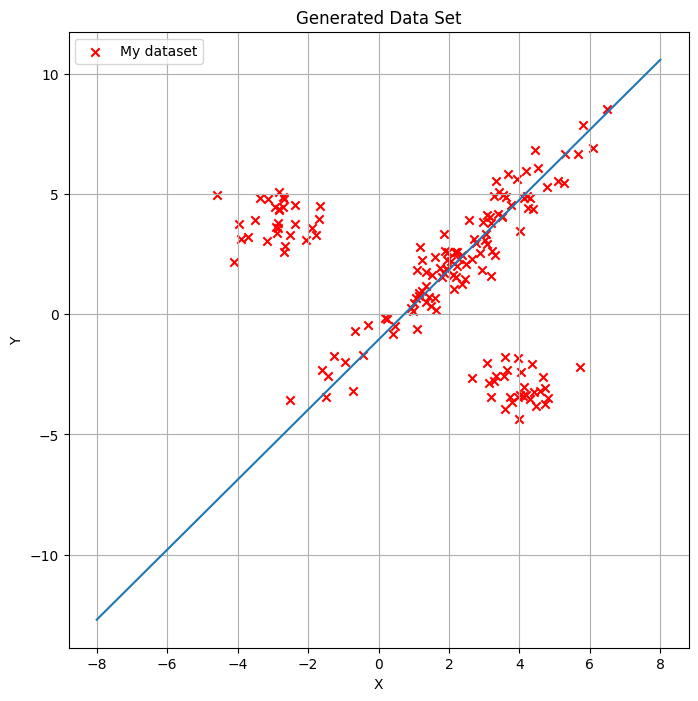

In [ ]:
from data import data
data = data()
ransac = SimpleRANSAC(threshold=.1)
point, scores = ransac.fit(data)

point1, point2 = point[0], point[1]
m = (point2[1] - point1[1]) / (point2[0] - point1[0])
b = point1[1] - m * point1[0]
x_values = np.linspace(-8, 8, 100) 
y_values = m * x_values + b

plt.figure(figsize=(8, 8))
plt.scatter(data[:, 0], data[:, 1], c='r', marker='x', label='My dataset')
plt.plot(x_values, y_values)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Generated Data Set')
plt.legend()
plt.grid(True)
plt.show()